In [1]:
path = "search.xls"

In [2]:
import pandas as pd
import numpy as np

In [3]:
file = pd.read_excel(path, header=1)
schedule_df = pd.DataFrame(file)

In [21]:
# Constants to refer to columns
COURSE_NUM = "Course #"
START_TIME = "Start Time"
DAYS_OFFERED = "Days"
SUFFIX = "Suffix"

Problem 1

The on-line schedule makes it hard to see when classes are offered. So produce a table (or 
dataframe) that shows when classes are offered. Divide classes into Intro classes (150, 
150L, 160, 160L), lower division (200, 300 & 400) and upper division (500 & 600). See the 
table below. This may be the hardest problem in the assignment.

In [4]:
# Dataframe filtering for only the columns needed
starting_df = schedule_df[["Start Time", "Days", "Course #", "Suffix"]].copy().dropna(subset=["Start Time"])

In [5]:
# Conditions for masking out days of the week
# Keep TTR
# Masking out MW
mw_mask = ((starting_df[DAYS_OFFERED] == "MW") | (starting_df[DAYS_OFFERED] == "W") | (starting_df[DAYS_OFFERED] == "M"))

# Keep MW
# Masking out TTR
ttr_mask = ((starting_df[DAYS_OFFERED] == "T") | (starting_df[DAYS_OFFERED] =="TTH") | (starting_df[DAYS_OFFERED] == "TH"))

In [6]:
# Returns a dataframe with specified class and days offered with time as a key.
def createCourseDaysDf(course_range_df, days_mask, new_df_name):
    filtered_df = course_range_df.copy()
    
    # Placing a mask over the courses and suffix columns that do not match the days condition
    filtered_df.loc[days_mask, COURSE_NUM] = ""
    filtered_df.loc[days_mask, SUFFIX] = ""
    
    # Concatenating Course # and Suffix. 
    filtered_df[COURSE_NUM] = filtered_df[COURSE_NUM].astype(str) + filtered_df[SUFFIX].fillna('').astype(str) + ' ' 
    
    # Days offered and standalone suffix column are not needed in the final result
    filtered_df = filtered_df.drop(columns=[DAYS_OFFERED, SUFFIX])

    # Rename, group by starting time and reset index to flatten the data in preparation to join
    filtered_df = filtered_df.rename(columns={COURSE_NUM : new_df_name})
    filtered_df = filtered_df.groupby(START_TIME).sum()
    filtered_df = filtered_df.reset_index()
    
    return filtered_df

In [7]:
intro_only_mask = (starting_df[COURSE_NUM] >= 200)

#Creating dataframe containing only introduction courses
intro_df = starting_df.copy()
intro_df.loc[intro_only_mask, COURSE_NUM] = ""
intro_df.loc[intro_only_mask, SUFFIX] = ""

In [8]:
lower_only_mask = (starting_df[COURSE_NUM] > 500) | (starting_df[COURSE_NUM] < 199)

#Creating dataframe containing only lower division courses
lower_df = starting_df.copy()
lower_df.loc[lower_only_mask, COURSE_NUM] = ""
lower_df.loc[lower_only_mask, SUFFIX] = ""
#lower_df

In [9]:
upper_only_mask = (starting_df[COURSE_NUM] < 499)

# Creating dataframe containing only upper division courses
upper_df = starting_df.copy()
upper_df.loc[upper_only_mask, COURSE_NUM] = ""
upper_df.loc[upper_only_mask, SUFFIX] = ""

In [10]:
# Introductory Courses Offered Monday's and/or Wednesdays
intro_mw_df = createCourseDaysDf(intro_df, ttr_mask, "Intro MW")

In [11]:
# Introductory Courses Offered Tuesdays's and/or Thursdays
intro_tth_df = createCourseDaysDf(intro_df, mw_mask, "Intro TTH")

In [12]:
# Lower Division Courses Offered Monday's and/or Wednesdays
lower_mw_df = createCourseDaysDf(lower_df, ttr_mask, "Lower MW")

In [13]:
# Lower Division Courses Offered Tuesdays's and/or Thursdays
lower_tth_df = createCourseDaysDf(lower_df, mw_mask, "Lower TTH")

In [14]:
# Upper Division Courses Offered Monday's and/or Wednesdays
upper_mw_df = createCourseDaysDf(upper_df, ttr_mask, "Upper MW")

In [15]:
# Upper Division Courses Offered Tuesdays's and/or Thursdays
upper_tth_df = createCourseDaysDf(upper_df, mw_mask, "Upper TTH")

In [16]:
course_day_time_df = intro_mw_df.join(intro_tth_df.set_index(START_TIME), on=START_TIME)

# Having some issues performing a join on a list of Dataframes.. 
course_day_time_df = course_day_time_df.join(lower_mw_df.set_index(START_TIME), on=START_TIME)
course_day_time_df = course_day_time_df.join(lower_tth_df.set_index(START_TIME), on=START_TIME)
course_day_time_df = course_day_time_df.join(upper_mw_df.set_index(START_TIME), on=START_TIME)
course_day_time_df = course_day_time_df.join(upper_tth_df.set_index(START_TIME), on=START_TIME)

course_day_time_df

,Start Time,Intro MW,Intro TTH,Lower MW,Lower TTH,Upper MW,Upper TTH
0,800.0,,150L 150L 160L 160L,490,210 496,,578
1,930.0,,150,200,200,,
2,1100.0,,100 160L,,480 496,,549 581
3,1230.0,,,,440,,
4,1400.0,150 160L 160,160,370 490,240 250 320 460 460,578 582 582,
5,1530.0,,160L 160L,,320,,
6,1600.0,160,150,210 370 496,480,532 574 574,514 549
7,1730.0,150L 150L 160L 160L 160,150L 150L,460 490 490,440 480,530 530 696 696,596 596 605 649 649
8,1900.0,,,240 490 490 490,,514 514 574 662 662,530 583


Problem 2

A number of classes have multiple sections making it hard to see how many students are 
taking each class. Produce and show a dataframe that shows how many students are in 
each class. Show the entire dataframe.

In [17]:
#Filter for 'Title', 'Course #', and 'Total Enrolled' columns
students_per_class_df = schedule_df[['Course #', 'Title', 'Total Enrolled']]

# Summing the total number of students enrolled for each unique course
students_per_class_df = students_per_class_df.groupby(['Course #', 'Title']).sum()
students_per_class_df

Total Enrolled
Course # Title                                    
100      COMPTR SCIENCE PRINCIPLES            38.0
150      INTRO COMPUTER PROGRAMMNG           175.0
         INTRO COMPUTER PROGRM LAB           288.0
160      INT COMPUTER PROGRAMMING            221.0
         INT COMPUTR PROGAMMNG LAB           430.0
200      INTRO DATA SCIENCE PYTHON            22.0
210      DATA STRUCTURES                      64.0
240      COMPUTER ORGANIZATION                65.0
250      INTRO TO SOFTWARE SYSTEMS            57.0
299      SPECIAL STUDY                         0.0
320      PROGRAMMING LANGUAGES                98.0
370      COMPUTER ARCHITECTURE               127.0
440      SOCIAL AND ETHICAL ISSUES            85.0
460      ALGORITHMS                          115.0
480      OPERATING SYSTEMS                   180.0
490      SENIOR SEMINAR                      121.0
496      DATA STRUC SCINTS &ENGNRS            89.0
497      UNDERGRAD RESRCH SEMINAR              0.0
498      UNDERGRAD HONORS THESIS               0.0
499      SPECIAL STUDY                         1.0
514      DATABASE THEORY IMPLEMENT           132.0
530      SYSTEMS PROGRAMMING                 121.0
532      SOFTWARE ENGINEERING                 67.0
549      MACHINE LEARNING                    115.0
574      COMPUTER SECURITY                   148.0
578      WIRELESS NETWORKS                   117.0
581      COMPUTATIONAL LINGUISTICS            15.0
582      INTRO SPEECH PROCESSING              30.0
583      3D GAME PROGRAMMING                  77.0
596      ADV 3D GAME PRGRMNG                  27.0
605      SCIENTIFIC COMPUTING                  9.0
649      BIG DATA TOOLS & METHODS             60.0
653      DATA MINING AND KNOWLEDGE             0.0
662      THEORY OF PARALLEL ALGORS            60.0
696      MODERN CRYPTOGRPHY & APPS            25.0
790      PRACT TEACHING COMP SCI               0.0
792      CURR PRACTICAL TRAINING               3.0
797      RESEARCH                              0.0
798      SPECIAL STUDY                         0.0
799      COMPREHENSIVE EXAM                    1.0
         THESIS OR PROJECT                     1.0
         THESIS OR PROJECT EXTEN               0.0

Problem 3

Produce and show a dataframe that shows how many classes are held in each classroom.

In [18]:
# Filter for Building and Room columns
class_df = schedule_df[['Building', 'Room']]
class_df = class_df.dropna()

# Size will return total number of elements for that particular Building + Room combination
classes_per_room = class_df.groupby(['Building', 'Room']).size()

# Rows that do not have a building or room associated
# with them are automatically dropped by grouped by
classes_per_room = pd.DataFrame(classes_per_room).reset_index()
classes_per_room.rename(columns={0: "Total Classes Held"})

,Building,Room,Total Classes Held
0,AH,2116,2
1,AL,101,1
2,AL,204,1
3,COM,105,1
4,COM,207,1
5,ENS,291,1
6,GMCS,305,1
7,GMCS,306,1
8,GMCS,308,2
9,GMCS,314,1


Problem 4 
Produce and show, a dataframe that shows how many students are in a class at a given time on Tuesday & Thursday. For each time there will be one number - the number of students in all the classed at that time.

In [26]:
TOTAL_STUDENTS_IN_CLASS = "Total Students in Class"

in_class_df = schedule_df[["Days", "Start Time", "End Time", "Total Enrolled"]]
in_class_df = in_class_df.rename(columns={"Total Enrolled": "Total Students in Class"})
in_class_df = in_class_df[(in_class_df.Days == 'TTH') | (in_class_df.Days == 'T') | (in_class_df.Days == 'TH')]
in_class_df = in_class_df.groupby(["Start Time", "End Time"]).sum()
in_class_df

Total Students in Class
Start Time End Time                         
800.0      915.0                       191.0
930.0      1045.0                       71.0
1100.0     1215.0                      235.0
1230.0     1345.0                       51.0
1400.0     1515.0                      298.0
1530.0     1645.0                       94.0
1600.0     1715.0                      160.0
           1840.0                       65.0
1730.0     1845.0                      247.0
1900.0     2015.0                      142.0

Problem 5
Produce a bar chart showing the number of students in classes at each time. That is the 
result of problem 4.

<AxesSubplot:xlabel='Time Range'>

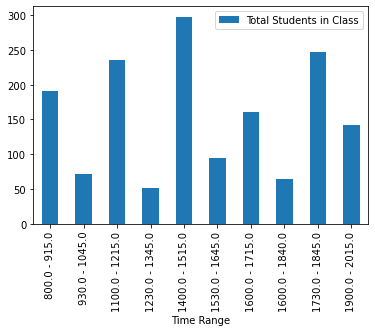

In [27]:
in_class_df = in_class_df.reset_index()
in_class_df['Time Range'] = in_class_df['Start Time'].astype(str) + ' - ' +  in_class_df['End Time'].astype(str)
in_class_df.plot.bar(y=TOTAL_STUDENTS_IN_CLASS, x='Time Range')